## Common Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')

import warnings; warnings.simplefilter('ignore')
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## Importing Pure Frequency Oracles from multi_freq_ldpy

In [2]:
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client, GRR_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.UE import UE_Client, UE_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.ADP import ADP_Client, ADP_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.LH import LH_Client, LH_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.SS import SS_Client, SS_Aggregator_MI
from multi_freq_ldpy.pure_frequency_oracles.HE import HE_Client, HE_Aggregator_MI

## Usage Example

In [3]:
k = 10 # number of values
input_data = 2 # real input value
eps = 1 # privacy guarantee

print('Real value:', input_data)
print('Sanitization w/ GRR protocol:', GRR_Client(input_data, k, eps)) 
print('Sanitization w/ OUE protocol:', UE_Client(input_data, k, eps, optimal=True))
print('Sanitization w/ OLH protocol:', LH_Client(input_data, k, eps, optimal=True)) # sanitized value, seed used to hash
print('Sanitization w/ SS protocol:', SS_Client(input_data, k, eps)) # set of sanitized values
print('Sanitization w/ HE protocol:', HE_Client(input_data, k, eps)) # histogram with Laplace noise

Real value: 2
Sanitization w/ GRR protocol: 3
Sanitization w/ OUE protocol: [1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
Sanitization w/ OLH protocol: (3, 9022264271050688788)
Sanitization w/ SS protocol: [2 8 9]
Sanitization w/ HE protocol: [ 0.83396732 -4.32236467 -0.35738156  3.36593103  0.59831725 -5.0482987
 -1.33927201  1.28171644  1.696612   -5.09499245]


## Reading Adult dataset with only 'age' attribute

In [4]:
df = pd.read_csv('datasets/db_adults.csv', usecols=['age'])
df

,age
0,39
1,50
2,38
3,53
4,28
...,...
45217,33
45218,39
45219,38
45220,44


## Encoding values

In [5]:
LE = LabelEncoder()

df['age'] = LE.fit_transform(df['age'])
df

,age
0,22
1,33
2,21
3,36
4,11
...,...
45217,16
45218,22
45219,21
45220,27


## Static Parameteres

In [6]:
# number of users (n)
n = df.shape[0]
print('Number of Users =',n)

# attribute's domain size
k = len(set(df['age']))
print("\nAttribute's domain size =", k)

print("\nPrivacy guarantees:")

# range of epsilon
lst_eps = np.arange(0.5, 5.1, 0.5)
print('Epsilon values =', lst_eps)

Number of Users = 45222

Attribute's domain size = 74

Privacy guarantees:
Epsilon values = [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


## Comparison of frequency oracles

In [7]:
# Real normalized frequency
real_freq = np.unique(df, return_counts=True)[-1] / n

# Repeat nb_seed times since DP protocols are randomized
nb_seed = 30

# Save Mean Squared Error (MSE) between real and estimated frequencies per seed
dic_mse = {seed: 
               {
                "GRR": [],
                "SUE": [],
                "OUE": [],
                "BLH": [],
                "OLH": [],
                "SS":  [],
                "SHE": [],
                "THE": []
               } 
               for seed in range(nb_seed)
          }

starttime = time.time()
for seed in range(nb_seed):
    print('Starting w/ seed:', seed)

    for eps in lst_eps:
        
        # GRR protocol
        grr_reports = [GRR_Client(input_data, k, eps) for input_data in df['age']]
        grr_est_freq = GRR_Aggregator_MI(grr_reports, k, eps)
        dic_mse[seed]["GRR"].append(mean_squared_error(real_freq, grr_est_freq))

        # SUE protocol
        sue_reports = [UE_Client(input_data, k, eps, optimal=False) for input_data in df['age']]
        sue_est_freq = UE_Aggregator_MI(sue_reports, eps, optimal=False)
        dic_mse[seed]["SUE"].append(mean_squared_error(real_freq, sue_est_freq))

        # OUE protocol
        oue_reports = [UE_Client(input_data, k, eps, optimal=True) for input_data in df['age']]
        oue_est_freq = UE_Aggregator_MI(oue_reports, eps, optimal=True)
        dic_mse[seed]["OUE"].append(mean_squared_error(real_freq, oue_est_freq))

        # BLH protocol        
        blh_reports = [LH_Client(input_data, k, eps, optimal=False) for input_data in df['age']]
        blh_est_freq = LH_Aggregator_MI(blh_reports, k, eps, optimal=False)
        dic_mse[seed]["BLH"].append(mean_squared_error(real_freq, blh_est_freq))

        # OLH protocol       
        olh_reports = [LH_Client(input_data, k, eps, optimal=True) for input_data in df['age']]
        olh_est_freq = LH_Aggregator_MI(olh_reports, k, eps, optimal=True)
        dic_mse[seed]["OLH"].append(mean_squared_error(real_freq, olh_est_freq))
        
        # SS protocol       
        ss_reports = [SS_Client(input_data, k, eps) for input_data in df['age']]
        ss_est_freq = SS_Aggregator_MI(ss_reports, k, eps)
        dic_mse[seed]["SS"].append(mean_squared_error(real_freq, ss_est_freq))
        
        # SHE protocol
        he_reports = [HE_Client(input_data, k, eps) for input_data in df['age']]
        she_est_freq = HE_Aggregator_MI(he_reports, k, eps, use_thresh=False)
        dic_mse[seed]["SHE"].append(mean_squared_error(real_freq, she_est_freq))
        
        # THE protocol (same resports from HE but different aggregation)
        the_est_freq = HE_Aggregator_MI(he_reports, k, eps, use_thresh=True)
        dic_mse[seed]["THE"].append(mean_squared_error(real_freq, the_est_freq))
        
print('That took {} seconds'.format(time.time() - starttime))        

Starting w/ seed: 0
Starting w/ seed: 1
Starting w/ seed: 2
Starting w/ seed: 3
Starting w/ seed: 4
Starting w/ seed: 5
Starting w/ seed: 6
Starting w/ seed: 7
Starting w/ seed: 8
Starting w/ seed: 9
Starting w/ seed: 10
Starting w/ seed: 11
Starting w/ seed: 12
Starting w/ seed: 13
Starting w/ seed: 14
Starting w/ seed: 15
Starting w/ seed: 16
Starting w/ seed: 17
Starting w/ seed: 18
Starting w/ seed: 19
Starting w/ seed: 20
Starting w/ seed: 21
Starting w/ seed: 22
Starting w/ seed: 23
Starting w/ seed: 24
Starting w/ seed: 25
Starting w/ seed: 26
Starting w/ seed: 27
Starting w/ seed: 28
Starting w/ seed: 29
That took 2217.6333932876587 seconds


## Plotting metrics results

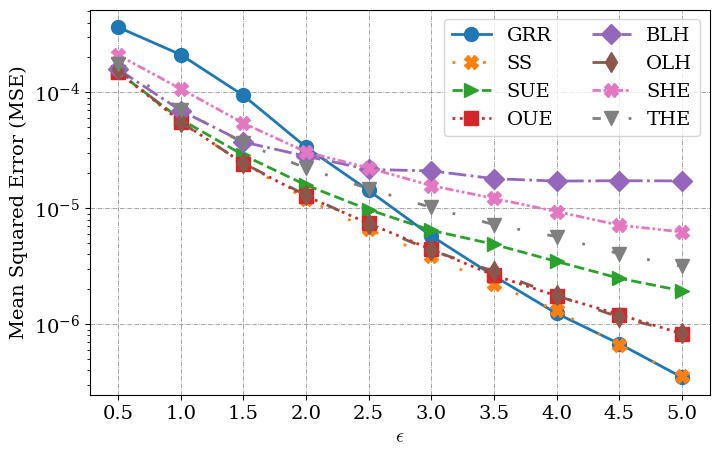

In [8]:
plt.figure(figsize=(8,5))
plt.grid(color='grey', linestyle='dashdot', linewidth=0.5)
plt.plot(np.mean([dic_mse[seed]["GRR"] for seed in range(nb_seed)], axis=0), label='GRR', marker='o')
plt.plot(np.mean([dic_mse[seed]["SS"] for seed in range(nb_seed)], axis=0), label='SS',marker='X',linestyle=(0, (1, 10)))
plt.plot(np.mean([dic_mse[seed]["SUE"] for seed in range(nb_seed)], axis=0), label='SUE',marker='>',linestyle='dashed')
plt.plot(np.mean([dic_mse[seed]["OUE"] for seed in range(nb_seed)], axis=0), label='OUE',marker='s',linestyle='dotted')
plt.plot(np.mean([dic_mse[seed]["BLH"] for seed in range(nb_seed)], axis=0), label='BLH', marker='D', linestyle='dashdot')
plt.plot(np.mean([dic_mse[seed]["OLH"] for seed in range(nb_seed)], axis=0), label='OLH',marker='d',linestyle=(0, (5, 10)))
plt.plot(np.mean([dic_mse[seed]["SHE"] for seed in range(nb_seed)], axis=0), label='SHE',marker='X',linestyle=(0, (3, 1, 1, 1, 1, 1)))
plt.plot(np.mean([dic_mse[seed]["THE"] for seed in range(nb_seed)], axis=0), label='THE',marker='v',linestyle=(0, (3, 10, 1, 10)))

plt.yscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(range(len(lst_eps)), lst_eps)
plt.legend(ncol=2)
plt.show()

## Example of Real vs Estimated Freqencies

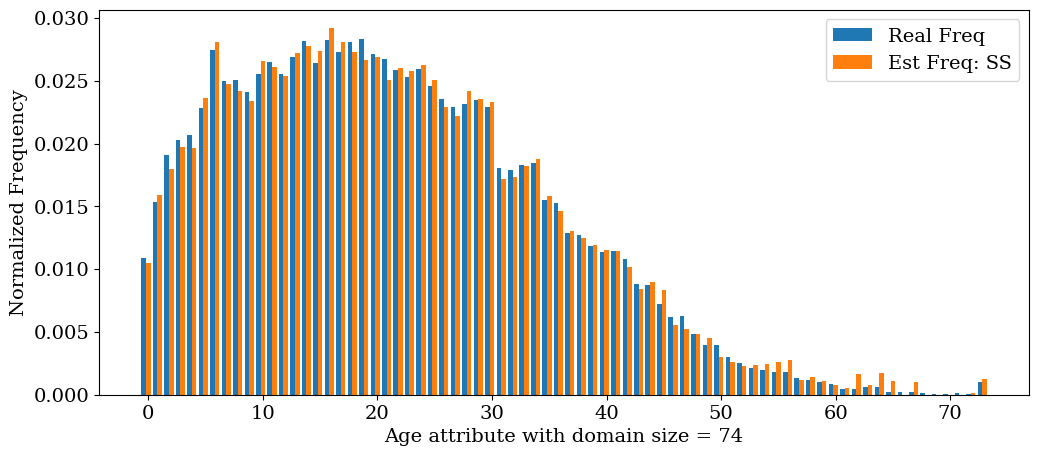

In [10]:
plt.figure(figsize=(12, 5))

barwidth = 0.4
x_axis = np.arange(k)

plt.bar(x_axis - barwidth, real_freq, label='Real Freq', width=barwidth)
plt.bar(x_axis, ss_est_freq, label='Est Freq: SS', width=barwidth)
plt.ylabel('Normalized Frequency')
plt.xlabel('Age attribute with domain size = {}'.format(k))
plt.legend()
plt.show();